## Polynomial Regression
Apply polynomial regression on real-world problem which has multi-dimension on input data.</br>

##### Data
There are 3 classes of 50 instances for each. </br>
The first 40 samples of each class are used as training set, and the last 10 samples as testing set.</br>

**Number of attributes**: 5 (4-dim input (data), 1-dim targrt (class-label))

In [231]:
import pandas as pd
import numpy as np
from numpy.linalg import pinv,inv,matrix_power
from scipy.io import loadmat

### Load and preprocess data

In [232]:
data_dir = './data/'
x = loadmat(data_dir+'5_X.mat')['X']
t = loadmat(data_dir+'5_T.mat')['T']
# print(tr)
# print(ts)

x_dim = 4
t_dim = 1
n_per_class = 50 
class_n = 3

# prepare to divide into training and testing
x = x.reshape(class_n,n_per_class,x_dim)
t = t.reshape(class_n,n_per_class)

# divide into train and test
tr_n_per_class = 40
ts_n_per_class = 10
tr_x = np.zeros((tr_n_per_class*class_n , x_dim))
ts_x = np.zeros((ts_n_per_class*class_n , x_dim))
tr_t = np.zeros(tr_n_per_class*class_n)
ts_t = np.zeros(ts_n_per_class*class_n)
for cls in range(class_n):
    tr_x[(cls)*tr_n_per_class:(cls+1)*tr_n_per_class] = x[cls][:tr_n_per_class]
    ts_x[(cls)*ts_n_per_class:(cls+1)*ts_n_per_class] = x[cls][tr_n_per_class:]
    tr_t[(cls)*tr_n_per_class:(cls+1)*tr_n_per_class] = t[cls][:tr_n_per_class]
    ts_t[(cls)*ts_n_per_class:(cls+1)*ts_n_per_class] = t[cls][tr_n_per_class:]

N_tr = len(tr_t)
N_ts = len(ts_t)


### Apply regression for class estimation by minimizing the non-regularized error function

The error function looks like below:

$$E(w) = \frac{1}{2}*\sum_{n=1}^{N}(y(x_n,w)-t_n)^{2} $$

However, since our input, x, now turn to be multi-dimension, the polynomial function should be generalized, here is an example of order=2 (**M=2**):


$$y(x,w) = w_0 + \sum_{i=1}^{D}w_i*x_i + \sum_{i=1}^{D}\sum_{j=1}^{D}w_{ij}*x_i*x_j $$

note that in this problem, the dimension, D, equals to 4

In [235]:
'''
compare to preoblem4, the only difference is the form of 'phi', o.w. the other stuffs like the solution of W still 
equals to (phi^T * phi)^-1 * phi^T * t.
phi = [[x1^0,x1^1....x1^M],[x2^0,x2^1....x2^M], .... [xN^0,xN^1....xN^M]], while each x1, x2, ... xN are all in 
'Vector' form.
t = [t1,t2,t3 ... ,tN], which are just 'class-label' of each xN
'''
def VecPower(vec, power):
    vec = np.asarray(vec).reshape(1,len(vec))
    mat_prev = 1
    for i in range(power):
        mat = np.dot(mat_prev,  vec)
        mat_prev = mat.reshape(-1,1) # reshape as (_,1) to preapre next for-loop matrix-multiplication
    
    result = mat.reshape(1,-1)[0]
    return result

tr_rms_ary = []
ts_rms_ary = []
Ms = [1,2]
for M in Ms:
    W_mat = [] 
    # Init data-num, valu-M and matrix-initialization
    # initial phi_mat with [[x1^{0}],[x2^{0}], ... ,[xN^{0}]], and turn it into list-type to prepare concate.
    Phi_mat = [list(x) for x in np.ones((N_tr,1))]
    T = np.zeros((N_tr,1))
    W = []

    for r_idx in range(N_tr):
        X_mat.append([1])# xN^{0} = 1
        for c_idx in range(M):
            # concate diff. power of same xN result in one row
            Phi_mat[r_idx] = Phi_mat[r_idx] + list(VecPower(tr_x[r_idx],c_idx+1))
        T[r_idx][0] = tr_t[r_idx]

    Phi_mat = np.asarray(Phi_mat)
    
    # Start calculating W result
    W = np.dot( pinv(Phi_mat) , T)
    
    # save w-vector power and later use in y(x,w)
    s_p = 0
    for i in range(M+1):
        size_w = x_dim**i
        W_mat.append(W[s_p:s_p+size_w])
        s_p += size_w
        
#     print(W)
#     print(W_mat[1])
#     print(X_mat[1])
    
    
    # Root mean square
    def poly_func (input_data, m):
        val = 0    
        for i in range(m+1): 
            if i == 0:
                x_ = 1
            elif i == 1:
                x_ = np.asarray(input_data)
                x_ = x_.reshape(1,-1)[0]
            elif i == 2:
                x_ = np.asarray([[x*y for y in input_data] for x in input_data])
                x_ = x_.reshape(1,-1)[0]

            w_ = W_mat[i].reshape(1,-1)[0]
            val += np.sum(x_ * w_)
            
        return val

    def Cal_rms(length, input_data, target_data, W, m):
        Err = 0
        for n in range(length):
            # careful on the transpose result have to index into it again
            Err += (poly_func(input_data[n], m) - target_data[n])**2 
        Err /= 2
        RMS_err = np.sqrt((2*Err)/length)
        
        return RMS_err
    
    RMS_err_tr = Cal_rms(N_tr, tr_x, tr_t, W, M)
    RMS_err_ts = Cal_rms(N_ts, ts_x, ts_t, W, M)
    tr_rms_ary.append(RMS_err_tr)
    ts_rms_ary.append(RMS_err_ts)
    
    print('training rms-Err for M = %s is %s.' % (str(M),str(RMS_err_tr)))
    print('testing rms-Err for M = %s is %s.' % (str(M),str(RMS_err_ts)))

training rms-Err for M = 1 is 0.226279143015.
testing rms-Err for M = 1 is 0.171124893337.
training rms-Err for M = 2 is 0.188594629096.
testing rms-Err for M = 2 is 0.153232445343.


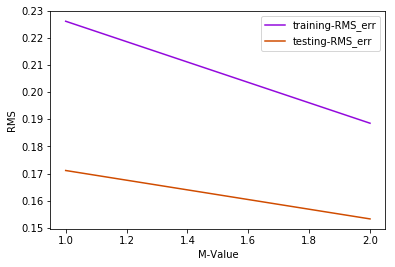

In [236]:
# visualize result
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(1,3),tr_rms_ary ,color=colors[1], label='training-RMS_err'.format(i=0))
plt.plot(range(1,3),ts_rms_ary ,color=colors[2], label='testing-RMS_err'.format(i=1))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
# plt.axis([0, 6, 0, 20])
plt.legend(loc='best')
plt.xlabel('M-Value')
plt.ylabel('RMS')
plt.savefig('hw1-5-(1)_non_regularize_multi-dim.png')

plt.show()
plt.close(fig)

In [242]:
#Find best attribute
    
tr_rms_ary = []
ts_rms_ary = []
M = 2
Min_rms_attri = None
Min_rms = np.inf
for dim in range(x_dim):
    tr_x_d = tr_x[:,:dim+1]
    ts_x_d = ts_x[:,:dim+1]
    
    W_mat = [] 
    # Init data-num, valu-M and matrix-initialization
    # initial phi_mat with [[x1^{0}],[x2^{0}], ... ,[xN^{0}]], and turn it into list-type to prepare concate.
    Phi_mat = [list(x) for x in np.ones((N_tr,1))]
    T = np.zeros((N_tr,1))
    W = []

    for r_idx in range(N_tr):
        X_mat.append([1])# xN^{0} = 1
        for c_idx in range(M):
            # concate diff. power of same xN result in one row
            Phi_mat[r_idx] = Phi_mat[r_idx] + list(VecPower(tr_x_d[r_idx],c_idx+1))
        T[r_idx][0] = tr_t[r_idx]

    Phi_mat = np.asarray(Phi_mat)
    
    # Start calculating W result
    W = np.dot( pinv(Phi_mat) , T)
    
    # save w-vector power and later use in y(x,w)
    s_p = 0
    for i in range(M+1):
        size_w = (dim+1)**i
        W_mat.append(W[s_p:s_p+size_w])
        s_p += size_w
        
#     print(W)
#     print(W_mat)
#     print(X_mat[1])
    
    
    # Root mean square
    def poly_func (input_data, m):
        val = 0    
        for i in range(m+1): 
            if i == 0:
                x_ = 1
            elif i == 1:
                x_ = np.asarray(input_data)
                x_ = x_.reshape(1,-1)[0]
            elif i == 2:
                x_ = np.asarray([[x*y for y in input_data] for x in input_data])
                x_ = x_.reshape(1,-1)[0]

            w_ = W_mat[i].reshape(1,-1)[0]
            val += np.sum(x_ * w_)
            
        return val

    def Cal_rms(length, input_data, target_data, W, m):
        Err = 0
        for n in range(length):
            # careful on the transpose result have to index into it again
            Err += (poly_func(input_data[n], m) - target_data[n])**2 
        Err /= 2
        RMS_err = np.sqrt((2*Err)/length)
        
        return RMS_err
    
    RMS_err_tr = Cal_rms(N_tr, tr_x_d, tr_t, W, M)
    RMS_err_ts = Cal_rms(N_ts, ts_x_d, ts_t, W, M)
    tr_rms_ary.append(RMS_err_tr)
    ts_rms_ary.append(RMS_err_ts)
    
    print('training rms-Err for dim = %s is %s.' % (str(dim+1),str(RMS_err_tr)))
#     print('testing rms-Err for dim = %s is %s.' % (str(dim+1),str(RMS_err_ts)))
    
    # update best RMS, and record the best sttribute
    if RMS_err_tr < Min_rms:
        Min_rms = RMS_err_tr
        Min_rms_attri = (dim+1)

training rms-Err for dim = 1 is 0.510306458755.
training rms-Err for dim = 2 is 0.411731232935.
training rms-Err for dim = 3 is 0.213847493016.
training rms-Err for dim = 4 is 0.188594629096.


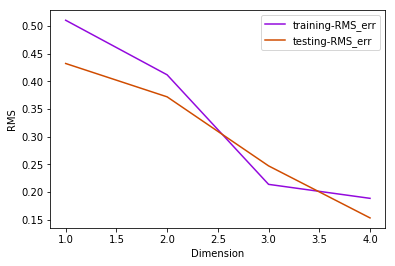

As the Figure show, we will choose attributes 4. Since it achieve lowest RMS value, 0.188594629096 


In [241]:
# visualize result
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(1,5),tr_rms_ary ,color=colors[1], label='training-RMS_err'.format(i=0))
plt.plot(range(1,5),ts_rms_ary ,color=colors[2], label='testing-RMS_err'.format(i=1))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
# plt.axis([0, 6, 0, 20])
plt.legend(loc='best')
plt.xlabel('Dimension')
plt.ylabel('RMS')
plt.savefig('hw1-5-(2)_atribute_decision.png')

plt.show()
plt.close(fig)
print('As the Figure show, we will choose attributes %d. Since it achieve lowest RMS value, %s .' % (Min_rms_attri,str(Min_rms)))

In [220]:
# test on dimension
print(type(ts_x))
print(ts_x.shape)
print(ts_x)
print(ts_x[:,:1])

<class 'numpy.ndarray'>
(30, 4)
[[ 5.   3.5  1.3  0.3]
 [ 4.5  2.3  1.3  0.3]
 [ 4.4  3.2  1.3  0.2]
 [ 5.   3.5  1.6  0.6]
 [ 5.1  3.8  1.9  0.4]
 [ 4.8  3.   1.4  0.3]
 [ 5.1  3.8  1.6  0.2]
 [ 4.6  3.2  1.4  0.2]
 [ 5.3  3.7  1.5  0.2]
 [ 5.   3.3  1.4  0.2]
 [ 5.5  2.6  4.4  1.2]
 [ 6.1  3.   4.6  1.4]
 [ 5.8  2.6  4.   1.2]
 [ 5.   2.3  3.3  1. ]
 [ 5.6  2.7  4.2  1.3]
 [ 5.7  3.   4.2  1.2]
 [ 5.7  2.9  4.2  1.3]
 [ 6.2  2.9  4.3  1.3]
 [ 5.1  2.5  3.   1.1]
 [ 5.7  2.8  4.1  1.3]
 [ 6.7  3.1  5.6  2.4]
 [ 6.9  3.1  5.1  2.3]
 [ 5.8  2.7  5.1  1.9]
 [ 6.8  3.2  5.9  2.3]
 [ 6.7  3.3  5.7  2.5]
 [ 6.7  3.   5.2  2.3]
 [ 6.3  2.5  5.   1.9]
 [ 6.5  3.   5.2  2. ]
 [ 6.2  3.4  5.4  2.3]
 [ 5.9  3.   5.1  1.8]]
[[ 5. ]
 [ 4.5]
 [ 4.4]
 [ 5. ]
 [ 5.1]
 [ 4.8]
 [ 5.1]
 [ 4.6]
 [ 5.3]
 [ 5. ]
 [ 5.5]
 [ 6.1]
 [ 5.8]
 [ 5. ]
 [ 5.6]
 [ 5.7]
 [ 5.7]
 [ 6.2]
 [ 5.1]
 [ 5.7]
 [ 6.7]
 [ 6.9]
 [ 5.8]
 [ 6.8]
 [ 6.7]
 [ 6.7]
 [ 6.3]
 [ 6.5]
 [ 6.2]
 [ 5.9]]
